In [1]:
from concurrent.futures import ThreadPoolExecutor, as_completed

import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from multiprocessing import Pool
from sklearn.preprocessing import StandardScaler

from keras.models import Model
from keras.optimizers import Adam
from keras.models import load_model
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Input, Conv1D, BatchNormalization, LeakyReLU, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout, Activation, Add, Flatten

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.callbacks import ModelCheckpoint

2024-07-31 23:08:38.762944: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 23:08:38.814071: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 23:08:38.814110: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 23:08:38.814142: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 23:08:38.823148: I tensorflow/core/platform/cpu_feature_g

# Load csv from Desktop

In [2]:
NUM_CLASSES = 2
CLASSES = np.array(['Legitimate', 'Suspicious'])
DATASET_DIR = "./"
VECTOR_LENGTH = 1 * 165

def csvToVector(file_path):
    data = pd.read_csv(file_path, header=None)
    vector = data.values.flatten()
    return vector

def process_file(class_idx, file_path):
    vector = csvToVector(file_path)
    return (vector, class_idx)

def load_data(dataset_dir):
    X = []
    y = []
    subdirs = ['benign_cms4', 'malware_cms4']
    futures = []

    with ThreadPoolExecutor() as executor:
        for class_idx, class_name in enumerate(subdirs):
            class_dir = os.path.join(dataset_dir, class_name)
            for file_name in os.listdir(class_dir):
                if file_name.endswith('.csv'):
                    file_path = os.path.join(class_dir, file_name)
                    futures.append(executor.submit(process_file, class_idx, file_path))

        for future in as_completed(futures):
            vector, class_idx = future.result()
            X.append(vector)
            y.append(class_idx)

    X = np.array(X)
    y = np.array(y)
    return X, y

In [3]:
X, y = load_data(DATASET_DIR)

In [4]:
print(X.shape)
print(y.shape)
print(X)
print(y)

(4020, 165)
(4020,)
[[  151 11580   167 ...     4   403    11]
 [  147 10605   145 ...     0   419     0]
 [  215 12959   213 ...     4   336    12]
 ...
 [   93  9696   127 ...     0   336     0]
 [  147 11389   145 ...     0   419     0]
 [  105  9084   148 ...     0   262     0]]
[1 0 1 ... 1 1 1]


# Train, Validation, Test Split and Nomalize

In [5]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=41)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=41)

X_train = X_train / 299.0
X_val = X_val / 299.0
X_test = X_test / 299.0

y_train = to_categorical(y_train, 2)
y_val = to_categorical(y_val, 2)
y_test = to_categorical(y_test, 2)

In [6]:
print(X_train.shape)
print(X_test.shape)
#print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
#print(y_val.shape)

(2251, 165)
(1206, 165)
(2251, 2)
(1206, 2)


# 1D CNN Architecture

In [7]:
input_layer = Input(shape=(VECTOR_LENGTH, 1))

x = Conv1D(filters=32, kernel_size=3, padding='same')(input_layer)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(filters=64, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(filters=128, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPooling1D(pool_size=2)(x)

x = Flatten()(x)

x = Dense(256)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate=0.5)(x)

x = Dense(NUM_CLASSES)(x)
output_layer = Activation('softmax')(x)

model = Model(input_layer, output_layer)

opt = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

2024-07-31 23:08:55.786460: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31350 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:06:00.0, compute capability: 7.0
2024-07-31 23:08:55.787007: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 31350 MB memory:  -> device: 1, name: CUDA GPU, pci bus id: 0000:2f:00.0, compute capability: 7.0
2024-07-31 23:08:55.787488: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 31350 MB memory:  -> device: 2, name: CUDA GPU, pci bus id: 0000:86:00.0, compute capability: 7.0


In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 165, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 165, 32)           128       
                                                                 
 batch_normalization (Batch  (None, 165, 32)           128       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 165, 32)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 82, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 82, 64)            6208  

# CheckPoint

In [27]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
checkpoint = ModelCheckpoint(
    filepath='/tmp/CMS4_CNN_1D_CheckPoint2.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

# Model Training

In [28]:
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[checkpoint])

Epoch 1/100
64/71 [==========================>...] - ETA: 0s - loss: 0.0420 - accuracy: 0.9800
Epoch 1: val_accuracy improved from -inf to 0.96625, saving model to /tmp/CMS4_CNN_1D_CheckPoint2.h5
71/71 [==============================] - 1s 8ms/step - loss: 0.0423 - accuracy: 0.9796 - val_loss: 0.1424 - val_accuracy: 0.9663
Epoch 2/100
19/71 [=======>......................] - ETA: 0s - loss: 0.0385 - accuracy: 0.9836

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


64/71 [==========================>...] - ETA: 0s - loss: 0.0363 - accuracy: 0.9858
Epoch 2: val_accuracy did not improve from 0.96625
71/71 [==============================] - 0s 7ms/step - loss: 0.0379 - accuracy: 0.9858 - val_loss: 0.1705 - val_accuracy: 0.9627
Epoch 3/100
64/71 [==========================>...] - ETA: 0s - loss: 0.0452 - accuracy: 0.9829
Epoch 3: val_accuracy did not improve from 0.96625
71/71 [==============================] - 0s 7ms/step - loss: 0.0455 - accuracy: 0.9822 - val_loss: 0.1621 - val_accuracy: 0.9556
Epoch 4/100
64/71 [==========================>...] - ETA: 0s - loss: 0.0412 - accuracy: 0.9805
Epoch 4: val_accuracy did not improve from 0.96625
71/71 [==============================] - 0s 7ms/step - loss: 0.0431 - accuracy: 0.9796 - val_loss: 0.1522 - val_accuracy: 0.9574
Epoch 5/100
64/71 [==========================>...] - ETA: 0s - loss: 0.0390 - accuracy: 0.9829
Epoch 5: val_accuracy did not improve from 0.96625
71/71 [==============================] - 

# Load Best CheckPoint

In [29]:
cp_model = load_model('/tmp/CMS4_CNN_1D_CheckPoint2.h5')
cp_model.evaluate(X_test, y_test, batch_size=1000)

2/2 [==============================] - 0s 13ms/step - loss: 0.1343 - accuracy: 0.9511


[0.1342962682247162, 0.951077938079834]

# Evaluate

In [30]:
y_pred = cp_model.predict(X_test)

38/38 [==============================] - 0s 2ms/step


In [31]:
preds_single = CLASSES[np.argmax(y_pred, axis = -1)]
actual_single = CLASSES[np.argmax(y_test, axis = -1)]

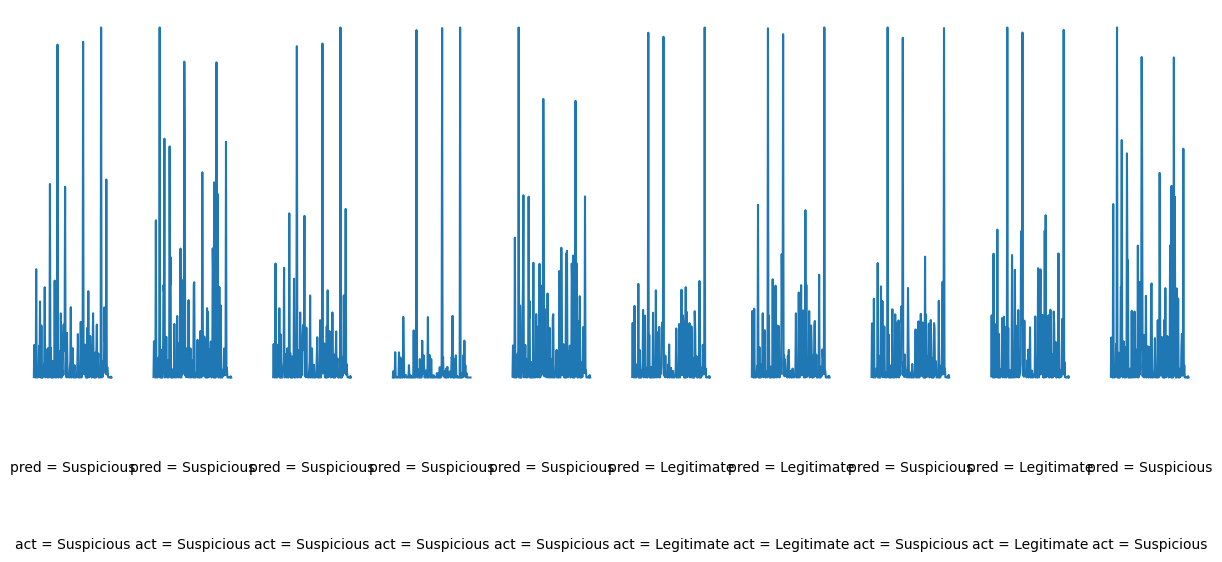

In [32]:
n_to_show = 10
indices = np.random.choice(range(len(X_test)), n_to_show)

fig = plt.figure(figsize=(15, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    data = X_test[idx]
    ax = fig.add_subplot(1, n_to_show, i+1)
    ax.plot(data)
    ax.axis('off')
    ax.text(0.5, -0.2, 'pred = ' + str(preds_single[idx]), fontsize=10, ha='center', transform=ax.transAxes) 
    ax.text(0.5, -0.4, 'act = ' + str(actual_single[idx]), fontsize=10, ha='center', transform=ax.transAxes)

plt.show()

# Classification Results

In [33]:
y_pred_classes = tf.argmax(y_pred, axis=1)
y_test_classes = tf.argmax(y_test, axis=1)

print(classification_report(y_test_classes, y_pred_classes, digits=4))

              precision    recall  f1-score   support

           0     0.9543    0.9528    0.9536       636
           1     0.9475    0.9491    0.9483       570

    accuracy                         0.9511      1206
   macro avg     0.9509    0.9510    0.9509      1206
weighted avg     0.9511    0.9511    0.9511      1206



# Confusion MatriX

In [34]:
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

class_labels = ['Legitimate', 'Suspicious']

conf_matrix_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)

print("Confusion Matrix:")
print(conf_matrix_df)

Confusion Matrix:
            Legitimate  Suspicious
Legitimate         606          30
Suspicious          29         541
